In [ ]:
%pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104.3 MB 80 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import models as moddd
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice



In [ ]:
import os
import pathlib
# folder path
dir_path = r'/content/gdrive/Shareddrives/DLSD/Images'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if pathlib.Path(dir_path+'/'+path).suffix != '.jpg':
          # os.remove(dir_path+'/'+path)
          count += 1
print('File count:', count)

KeyboardInterrupt: ignored

In [ ]:
#Directory paths
BASE_DIR = r'/content/gdrive/Shareddrives/DLSD/'
WORKING_DIR =  r'/content/gdrive/Shareddrives/DLSD/'

In [ ]:
#Class for metrics calclulation
class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

In [ ]:
#CNN models
def VGG16model():
  model = VGG16()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  print(model.summary())
  return model

def ResNet50model():
  model = ResNet50()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  return model

def VGG19model():
  model = VGG19()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  return model

def InceptionV3model():
  model = InceptionV3(input_tensor=Input(shape =(224, 224, 3)), weights='imagenet', include_top=True)
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  return model

def Xceptionmodel():
  model = Xception(input_tensor=Input(shape =(224, 224, 3)), weights='imagenet', include_top=True)
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  return model

In [ ]:
models = []
models.append(VGG16model())
models.append(ResNet50model())
models.append(VGG19model())
models.append(InceptionV3model())
models.append(Xceptionmodel())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
def getImageFeatures(model):
  features = {}
  directory = os.path.join(BASE_DIR, 'Images')

  for img_name in tqdm(os.listdir(directory)):
      img_path = directory + '/' + img_name
      image = load_img(img_path, target_size=(224, 224))
      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = preprocess_input(image)
      feature = model.predict(image, verbose=0)
      vector_len = len(feature[0])
      image_id = img_name.split('.')[0]
      features[image_id] = feature

  return features, vector_len

In [ ]:
#Dump feature vectors from CNN models and initialize feature vector length
featureLen = []
featuredict, vec_len = getImageFeatures(models[0])
featureLen.append(vec_len)
pickle.dump(featuredict, open(os.path.join(WORKING_DIR, 'featuresVGG16.pkl'), 'wb'))
featuredict, vec_len = getImageFeatures(models[1])
featureLen.append(vec_len)
pickle.dump(featuredict, open(os.path.join(WORKING_DIR, 'featuresVGG19.pkl'), 'wb'))
featuredict, vec_len = getImageFeatures(models[0])
featureLen.append(vec_len)
pickle.dump(featuredict, open(os.path.join(WORKING_DIR, 'featuresInceptionV3.pkl'), 'wb'))
featuredict, vec_len = getImageFeatures(models[1])
featureLen.append(vec_len)
pickle.dump(featuredict, open(os.path.join(WORKING_DIR, 'featuresXception.pkl'), 'wb'))

  0%|          | 0/8103 [00:00<?, ?it/s]

  0%|          | 0/8103 [00:00<?, ?it/s]

In [ ]:
#Load required features
with open(os.path.join(WORKING_DIR, 'featuresVGG16.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
#Create dictionaruy of captions for every image
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
#format every caption
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
len(features['945509052_740bb19bc3'][0])

2048

In [ ]:
clean(mapping)


In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [ ]:
len(all_captions)


40455

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
vocab_size


8485

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
def makeLSTMmodel(vocab_size, max_length):

    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())

    return model

In [ ]:
modelLSTM = makeLSTMmodel(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 256)      2172160     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

In [ ]:
len(features['871290666_4877e128c0'][0])

4096

In [ ]:
#train LSTM model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    modelLSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
modelLSTM.save(WORKING_DIR+'/InceptionV3LSTMmodel10epoch')

In [ ]:
modelLSTM = moddd.load_model(WORKING_DIR+"InceptionV3LSTMmodel10epoch")

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
imgIds = []
gts = {}
res = {}


for key in tqdm(test):
    imgIds.append(key)
    captions = mapping[key]
    y_pred = predict_caption(modelLSTM, features[key], tokenizer, max_length) 
    gts[key] = [{'image_id': key, 'caption': caption} for caption in captions]
    res[key] = [{'image_id': key, 'caption': y_pred}]
    
evalObj = COCOEvalCap(imgIds,gts,res)
evalObj.evaluate()

print(evalObj.eval)
 

  0%|          | 0/810 [00:00<?, ?it/s]

tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 8362, 'reflen': 7906, 'guess': [8362, 7552, 6742, 5932], 'correct': [4123, 995, 308, 84]}
ratio: 1.057677713129135
Bleu_1: 0.493
Bleu_2: 0.255
Bleu_3: 0.144
Bleu_4: 0.081
computing METEOR score...
METEOR: 0.188
computing Rouge score...
ROUGE_L: 0.420
computing CIDEr score...
CIDEr: 0.177
computing SPICE score...
SPICE: 0.123
{'Bleu_1': 0.4930638603204385, 'Bleu_2': 0.25487787376985716, 'Bleu_3': 0.143706169412657, 'Bleu_4': 0.0805148699469801, 'METEOR': 0.1878829693853365, 'ROUGE_L': 0.4201839671483624, 'CIDEr': 0.17721743066252554, 'SPICE': 0.12290076396613434}


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(modelLSTM, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq dog is running through the grass endseq


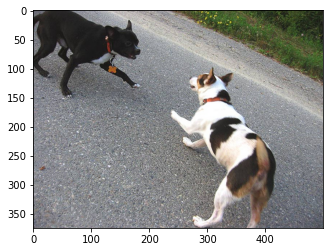

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")


---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq man in black shirt is sitting on the air endseq


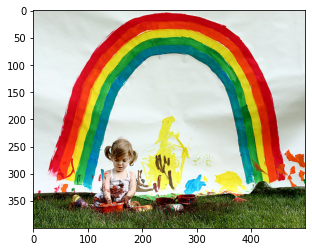

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq girl smiles as she runs across the white sandy beach in her swimsuit endseq
startseq little girl in flowered bathingsuit runs through the sand at the beach endseq
startseq little girl in flower swimsuit running across the beach with waves in the background endseq
startseq there is little girl running on the beach endseq
startseq the young girl is running on sandy beach endseq
--------------------Predicted--------------------
startseq little boy in pink shorts and pink shorts is walking on the beach endseq


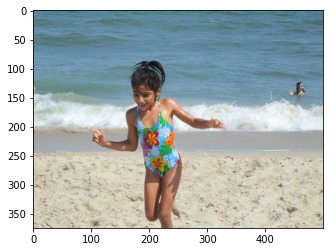

In [ ]:
generate_caption("1408958345_68eea9a4e4.jpg")